In [1]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import VAR

from statsmodels.tsa import filters
import pandas as pd
import numpy as np
import matplotlib as plt
import statsmodels.tsa.stattools as stt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
from sklearn import metrics
import statsmodels.api as sm

%matplotlib inline

In [54]:
data = pd.read_excel(r'C:/Users/IGOMEZ/Documents/IDGR/ProyectoGrado/Desarrollo/dataIndicadores.xlsx', sheet_name = 'Var_Men', encoding='utf-8')

data.Fecha = pd.to_datetime(data.Fecha)
data = data.set_index('Fecha')
data = data.dropna()

data.tail()

,IPP,IPC,BRENT,TRM,ISE,TASA_POL_MON,LIBOR
Fecha,,,,,,,
2019-01-01,0.005884,0.006000,0.150372,-0.015742,0.010035,0.0,0.000539
2019-02-01,0.009343,0.005765,0.066893,-0.014789,0.000294,0.0,-0.000153
2019-03-01,0.006661,0.004349,0.035741,0.003271,-0.010474,0.0,-0.000047
2019-04-01,0.014265,0.004920,0.064483,0.009561,0.019215,0.0,-0.000097
2019-05-01,0.015928,0.003134,-0.114148,0.049211,0.000909,0.0,-0.000358


### Pruebas ADFuller

In [55]:
# scaler = StandardScaler()
# data = scaler.fit_transform(data)
# data = pd.DataFrame(data2, columns=data.columns, index=data.index)

for i in data.columns.tolist():
    result = stt.adfuller(data[str(i)])
    pvalue = float(result[1])
    isStationary = pvalue <= 0.05
    print(i)
    print("P-VALUE TASA: ", pvalue, isStationary)
    print('*'*40)
    print(' ')

IPP
P-VALUE TASA:  2.1849371506292563e-14 True
****************************************
 
IPC
P-VALUE TASA:  0.05228765904157521 False
****************************************
 
BRENT
P-VALUE TASA:  5.6058934084297054e-08 True
****************************************
 
TRM
P-VALUE TASA:  7.805727795377145e-12 True
****************************************
 
ISE
P-VALUE TASA:  2.280294410754899e-10 True
****************************************
 
TASA_POL_MON
P-VALUE TASA:  0.009295971952215277 True
****************************************
 
LIBOR
P-VALUE TASA:  0.02993280106587222 True
****************************************
 


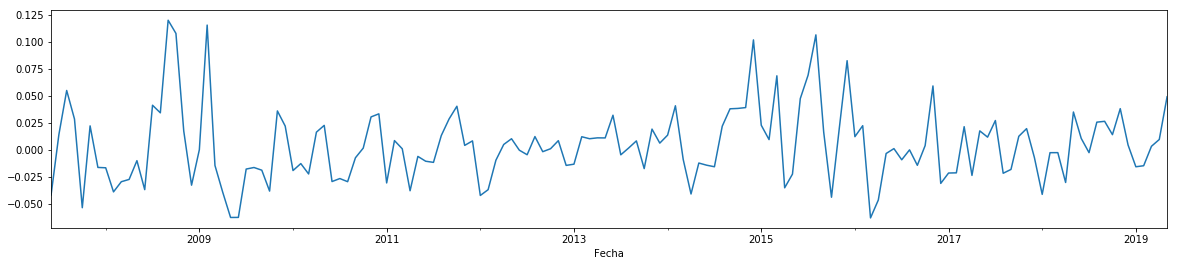

In [67]:
data['TRM'].plot(figsize=(20,4));

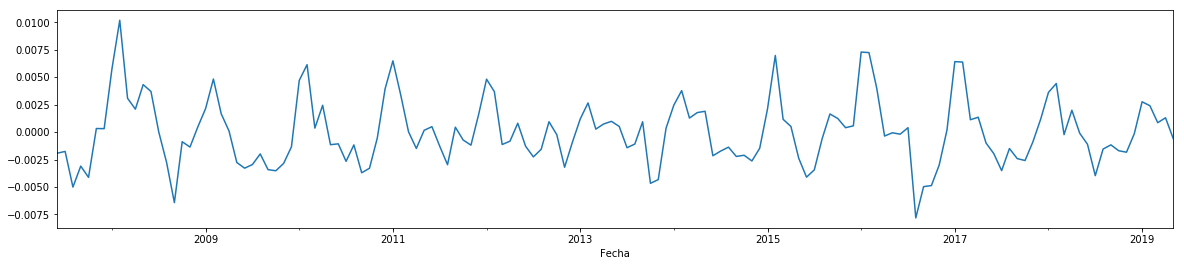

In [57]:
# Modificamos con el filtro de Hodrick-Prescott
cycle, trend = sm.tsa.filters.hpfilter(data.IPC, 1600)
data['IPC'] = cycle
data['IPC'].plot(figsize=(20,4));

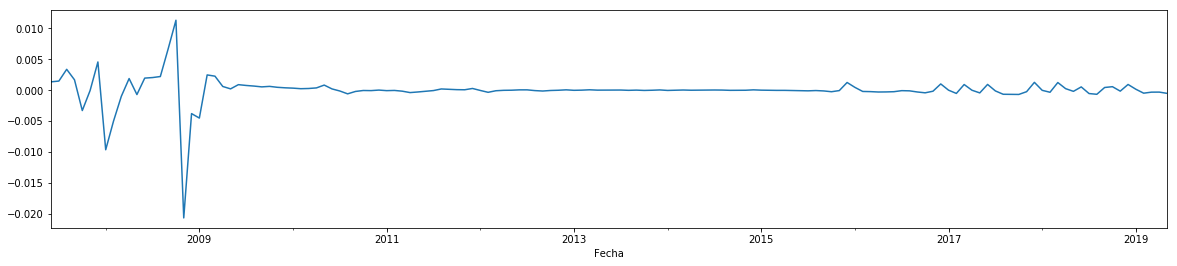

In [58]:
# Modificamos con el filtro de Hodrick-Prescott
cycle, trend = sm.tsa.filters.hpfilter(data.LIBOR, 1600)
data['LIBOR'] = cycle
data['LIBOR'].plot(figsize=(20,4));

In [59]:
# Volvemos a correr la prueba con los indicadores modificados por medio el filtro Hodrick-Prescott

for i in data.columns.tolist():
    result = stt.adfuller(data[str(i)])
    pvalue = float(result[1])
    isStationary = pvalue <= 0.05
    print(i)
    print("P-VALUE TASA: ", pvalue, isStationary)
    print('*'*40)
    print(' ')

IPP
P-VALUE TASA:  2.1849371506292563e-14 True
****************************************
 
IPC
P-VALUE TASA:  0.005648190130457582 True
****************************************
 
BRENT
P-VALUE TASA:  5.6058934084297054e-08 True
****************************************
 
TRM
P-VALUE TASA:  7.805727795377145e-12 True
****************************************
 
ISE
P-VALUE TASA:  2.280294410754899e-10 True
****************************************
 
TASA_POL_MON
P-VALUE TASA:  0.009295971952215277 True
****************************************
 
LIBOR
P-VALUE TASA:  1.5802808923631689e-09 True
****************************************
 


# Estimamos un modelo VAR
### Probamos la causalidad de la tasa con las demás variables

In [60]:
model = VAR(data)
results = model.fit(1)

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [61]:
var = data.columns.tolist()
del var[5]

for i in var:
    test = results.test_causality('TASA_POL_MON', str(i), kind='wald')
    print(i)
    print(test.summary())
    print(' ')

IPP
Granger causality Wald-test. H_0: IPP does not Granger-cause TASA_POL_MON. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    4.627          3.841       0.031  1 
----------------------------------------
 
IPC
Granger causality Wald-test. H_0: IPC does not Granger-cause TASA_POL_MON. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    0.2218         3.841       0.638  1 
----------------------------------------
 
BRENT
Granger causality Wald-test. H_0: BRENT does not Granger-cause TASA_POL_MON. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
    5.338          3.841       0.021  1 
----------------------------------------
 
TRM
Granger causality Wald-test. H_0: TRM does not Granger-cause TASA_POL_MON. Conclusion: fail to reject 

In [71]:
num_periodos_test = 36
result_ = []
resultSeries_ = []
df = pd.DataFrame()

flag = True

# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX

for i in range (0, num_periodos_test):
    
    #Dividir los datos en train and test
    div = len(data) - num_periodos_test + i
    train = data[:div]
    test_indicador = data[div:]
    
    model_Brent_Libor = VAR(train[['BRENT', 'LIBOR']])
    results_Brent_Libor = model_Brent_Libor.fit(1)
    Brent_Libor = pd.DataFrame(results_Brent_Libor.forecast(train[['BRENT', 'LIBOR']].values,1), columns=['BRENT', 'LIBOR'])    

    # Fit model
    model = VARMAX(train.drop(['BRENT', 'LIBOR'], axis=1), exog=train[['BRENT', 'LIBOR']], order=(1, 1))
    model_fit = model.fit()
    # Make prediction
    proy_var = pd.DataFrame(model_fit.forecast(exog=[Brent_Libor.loc[0].values]))

    if flag:
        df = pd.DataFrame(proy_var)
        flag = False
    else:
        df = df.append(pd.DataFrame(proy_var))

resultSeries_.append(df)

# resultRMSE_.append(np.sqrt(metrics.mean_squared_error(result_,data2[len(data2)-num_periodos_test:][['IPP']])))

# resultRMSE_

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\stat

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaco

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaco

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaco

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaco

C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\IGOMEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [72]:
data.head()

,IPP,IPC,BRENT,TRM,ISE,TASA_POL_MON,LIBOR
Fecha,,,,,,,
2007-06-01,-0.006589,-0.001925,0.049530,-0.041909,0.010554,0.0000,0.001351
2007-07-01,0.002842,-0.001764,0.078981,0.014092,0.001306,0.0025,0.001478
2007-08-01,0.011877,-0.005011,-0.056587,0.055057,0.009827,0.0000,0.003377
2007-09-01,0.012538,-0.003101,0.089146,0.028553,0.003624,0.0000,0.001681
2007-10-01,-0.001054,-0.004127,0.144752,-0.053749,0.001135,0.0025,-0.003297


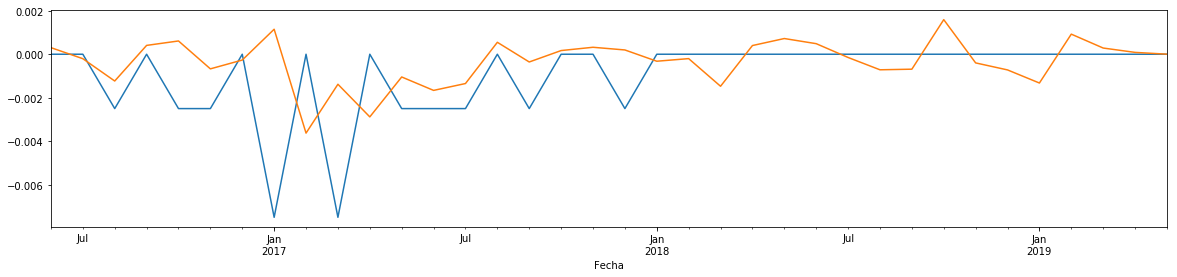

In [80]:

data[108:]['TASA_POL_MON'].plot(figsize=(20,4))
df['TASA_POL_MON'].plot(figsize=(20,4))

In [86]:
df[['TASA_POL_MON']].to_csv("Proy_BaseLine.csv")

In [74]:
resultRMSE_ = []
for column in df.columns.tolist():
    #print(df[column])
    resultRMSE_.append(np.sqrt(metrics.mean_squared_error(df[column],data[len(data)-num_periodos_test:][column])))
    medError = pd.DataFrame(resultRMSE_).T
    #medError = pd.DataFrame(medError.values, columns=df.columns.tolist())
medError = pd.DataFrame(medError.values, columns=df.columns.tolist())
medError

,IPP,IPC,TRM,ISE,TASA_POL_MON
0,0.009395,0.002426,0.025383,0.009433,0.002207


In [12]:
resultRMSE_ = []
for column in df.columns.tolist():
    #print(df[column])
    resultRMSE_.append(metrics.mean_absolute_error(df[column],data[len(data)-num_periodos_test:][column]))
    medError = pd.DataFrame(resultRMSE_).T
    #medError = pd.DataFrame(medError.values, columns=df.columns.tolist())
medError = pd.DataFrame(medError.values, columns=df.columns.tolist())
medError

,IPP,IPC,TRM,ISE,TASA_POL_MON
0,0.006981,0.001813,0.021958,0.007379,0.001508


In [13]:
from datetime import datetime
# datetime object containing current date and time

print("now =", datetime.now())

now = 2019-09-12 01:13:01.339242
